# April 9, 2025: 

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from scipy.spatial.distance import jensenshannon, squareform, pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from multiprocessing import Pool
import glob
import random
import re

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer

import arviz as az

import ants
from nipype.interfaces import afni
from nilearn.plotting import plot_stat_map

from itertools import product, combinations, chain
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [3]:
args.source ='allen' #'spatial' #'allen'
args.space = 'ccfv2' #'yale' #'ccfv2'
args.brain_div = 'whl' #'whl' #'whl'
args.num_rois = 172 #162 #172
args.resolution = 200 #200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [5]:
args.dc, args.sbm = False, 'h'

args.nested = True if args.sbm in ['h'] else False

args.force_niter = 40000
args.num_draws = int((1/2) * args.force_niter)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['m', 'a'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

In [6]:
template_file = f'{PARCELS_path}/source-{args.source}_space-{args.space}_res-{args.resolution}_desc-template.nii.gz'
template_img = ants.image_read(template_file)
template_img

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (57, 40, 66)
	 Spacing    : (0.2, 0.2, 0.2)
	 Origin     : (5.78, 7.83, -6.93)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [7]:
parcels_img = ants.image_read(f'{PARCELS_path}/{PARC_DESC}_desc-parcels.nii.gz')

try:
    roi_labels = pd.read_csv(f'{PARCELS_path}/{PARC_DESC}_desc-names.csv')['roi'].to_list()
except:
    roi_labels = np.arange(1, args.num_rois+1)

In [8]:
folder = (
    f'{ESTIM_path}/group/membership-mats-group-aligned'
    f'/{SBM}/marginal-visuals/res-{args.resolution}/nii'
)
comms_img_files = sorted(glob.glob(f'{folder}/*.nii.gz', recursive=True))
comms_img_files

['/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/nii/mode-00_level-0.nii.gz',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/estimates/group/membership-mats-group-aligned/sbm-nd-h/marginal-visuals/res-200/nii/mode-00_level-1.nii.gz']

In [9]:
def plot_comms_nilearn(comms_img_file):
    fs = comms_img_file.split('/')
    id = fs[-1].split('.')[0]
    out_file = '/'.join(fs[:-1] + [f'{id}.pdf'])

    comms_img = ants.image_read(comms_img_file)
    comms_vol = comms_img.numpy()
    num_comms = min(23, comms_vol.shape[-1])

    ncols = 5
    nrows = np.ceil(num_comms / ncols).astype(int)
    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
    fig.tight_layout(h_pad=0, w_pad=0)

    for idx_comm in tqdm(range(num_comms)):
        r, c = idx_comm // ncols, idx_comm % ncols
        ax = axs[r, c] if nrows > 1 else axs[c]
        
        comm_vol = comms_vol[:, :, :, idx_comm]
        template_img.new_image_like(comm_vol).to_file(f'comm_img.nii.gz')

        plot_stat_map(
            stat_map_img=f'comm_img.nii.gz',
            bg_img=template_file,
            threshold=0.2,
            black_bg=False,
            dim=1.0,
            vmin=0.0, 
            vmax=1.0,
            cmap=cc.cm.CET_L12,
            display_mode='ortho',
            axes=ax,
            title=f'comm: {idx_comm:02d}',
        )

        # break
    for c_ in range(c+1, ncols):
        ax = axs[r, c_] if nrows > 1 else axs[c_]
        fig.delaxes(ax)

    fig.savefig(f'{out_file}', transparent=True, bbox_inches='tight')
    return fig

100%|██████████| 21/21 [01:00<00:00,  2.89s/it]


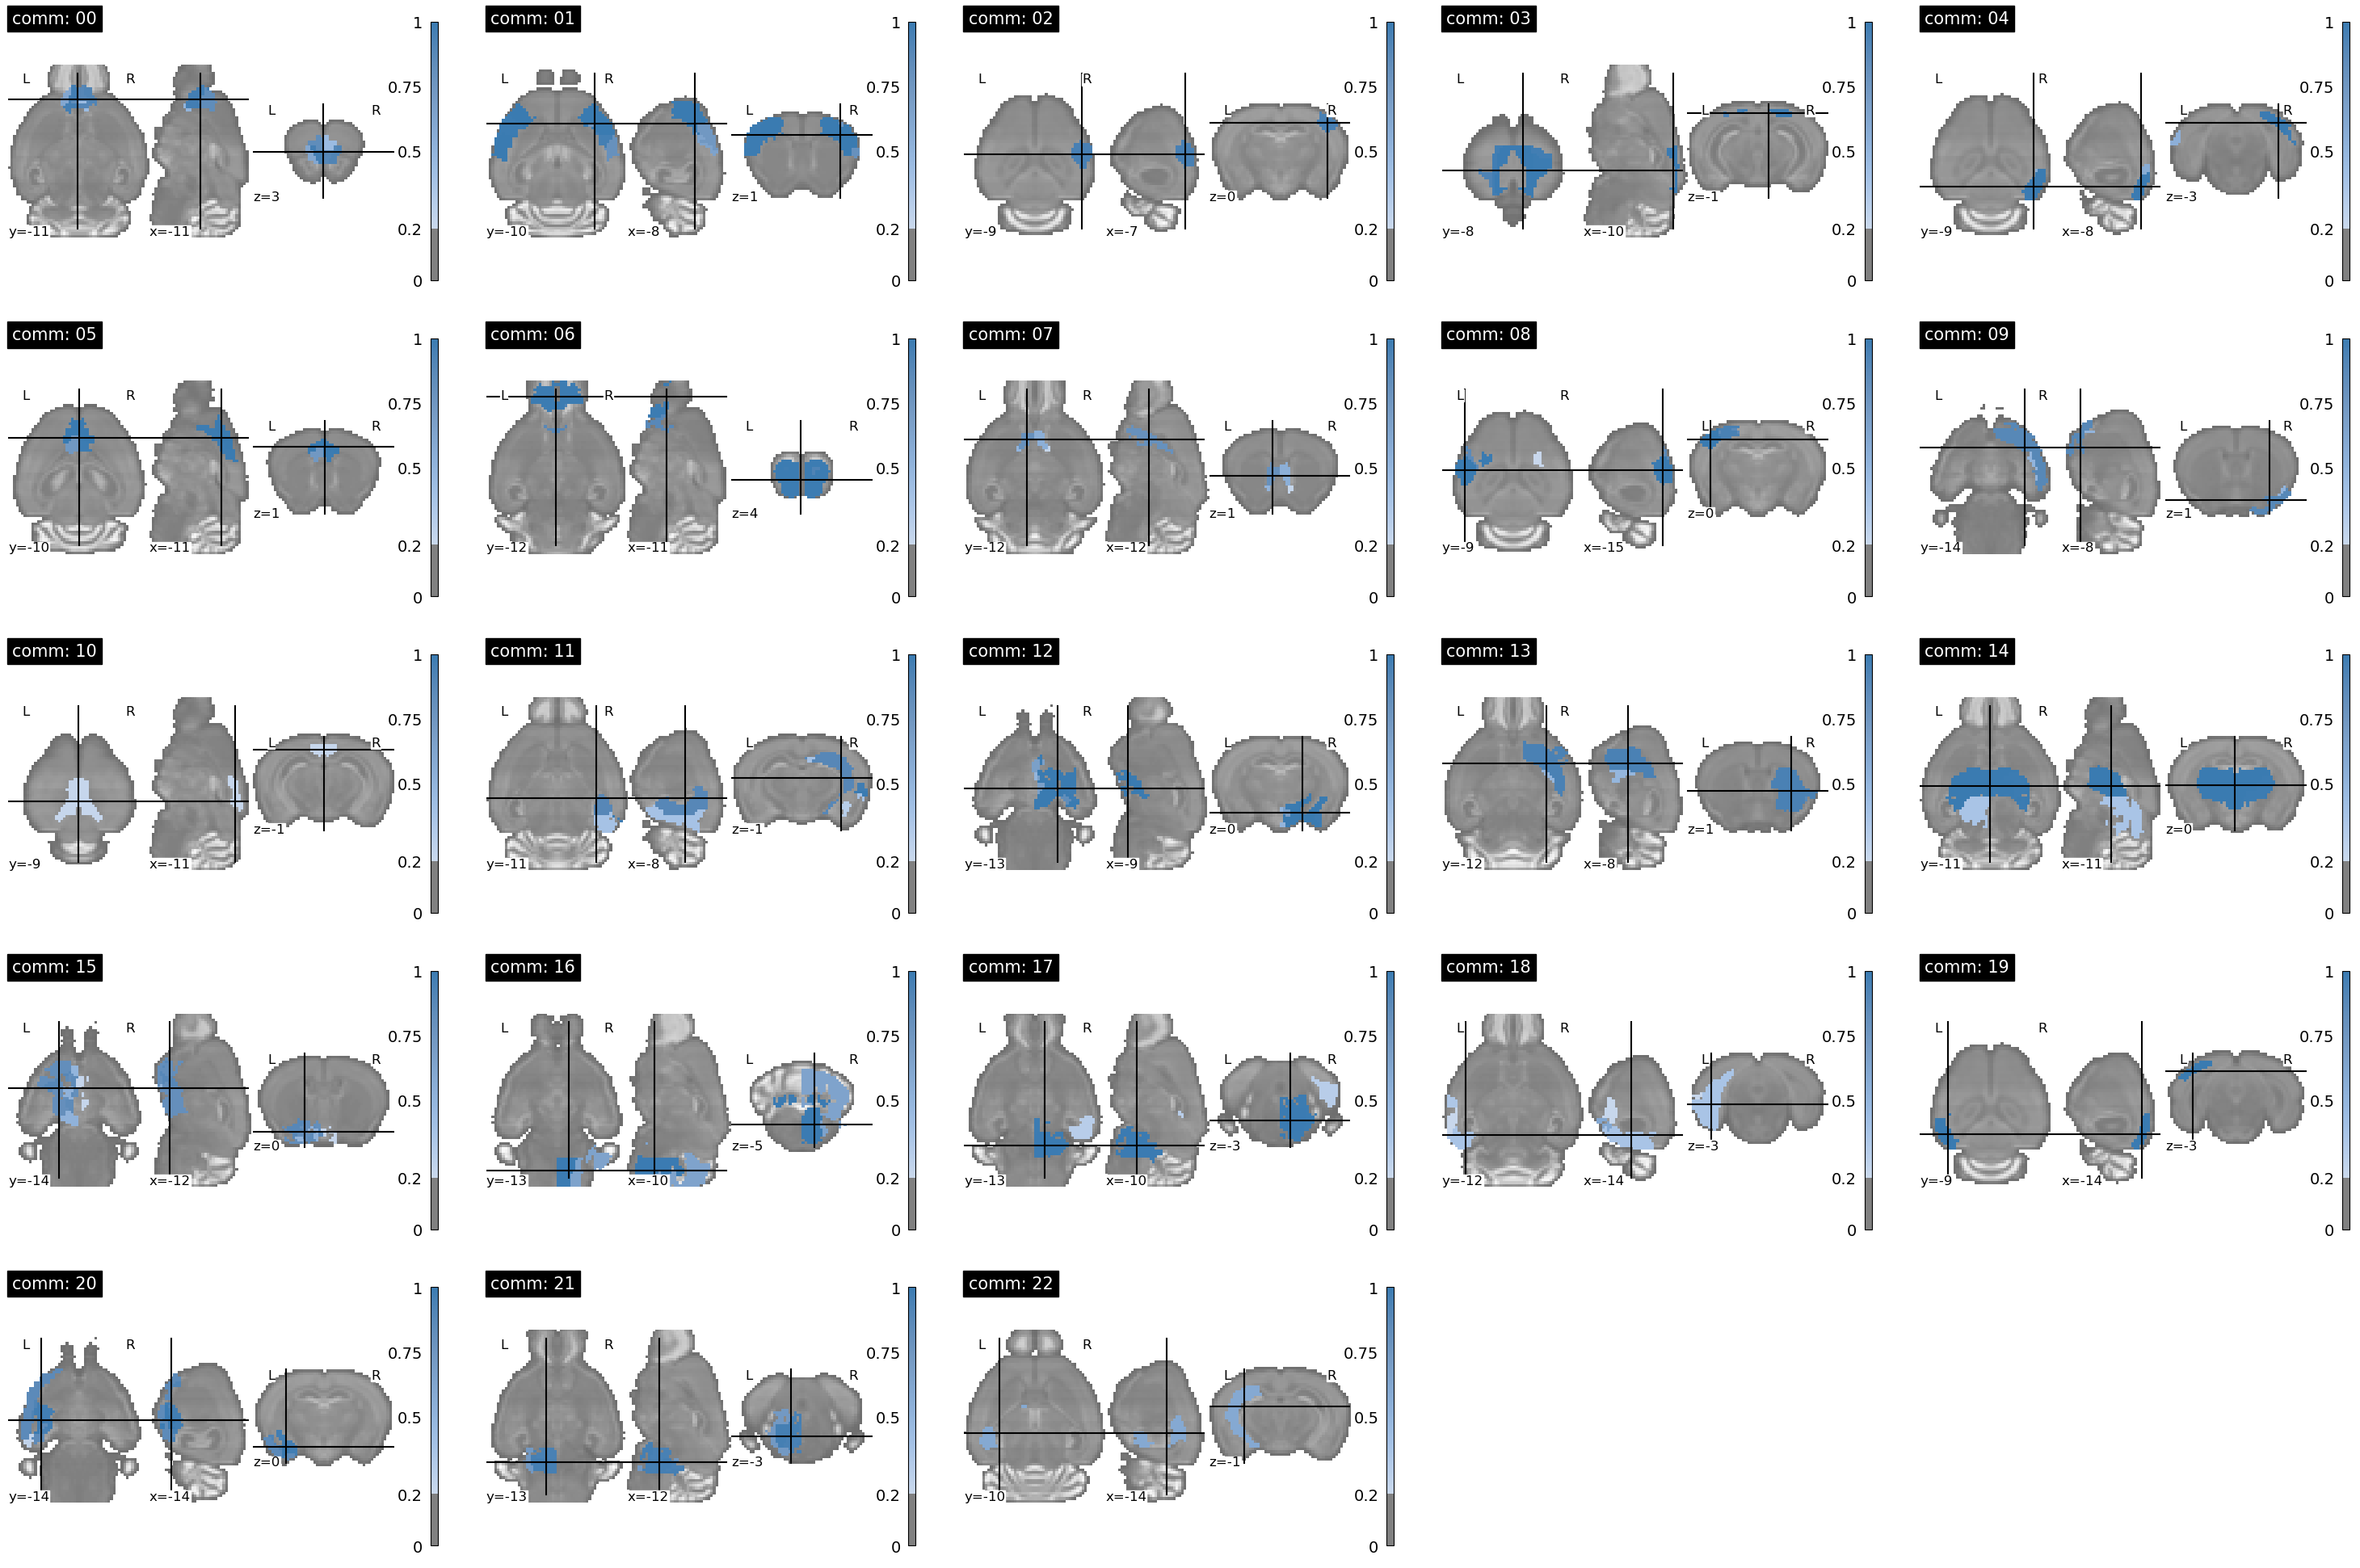

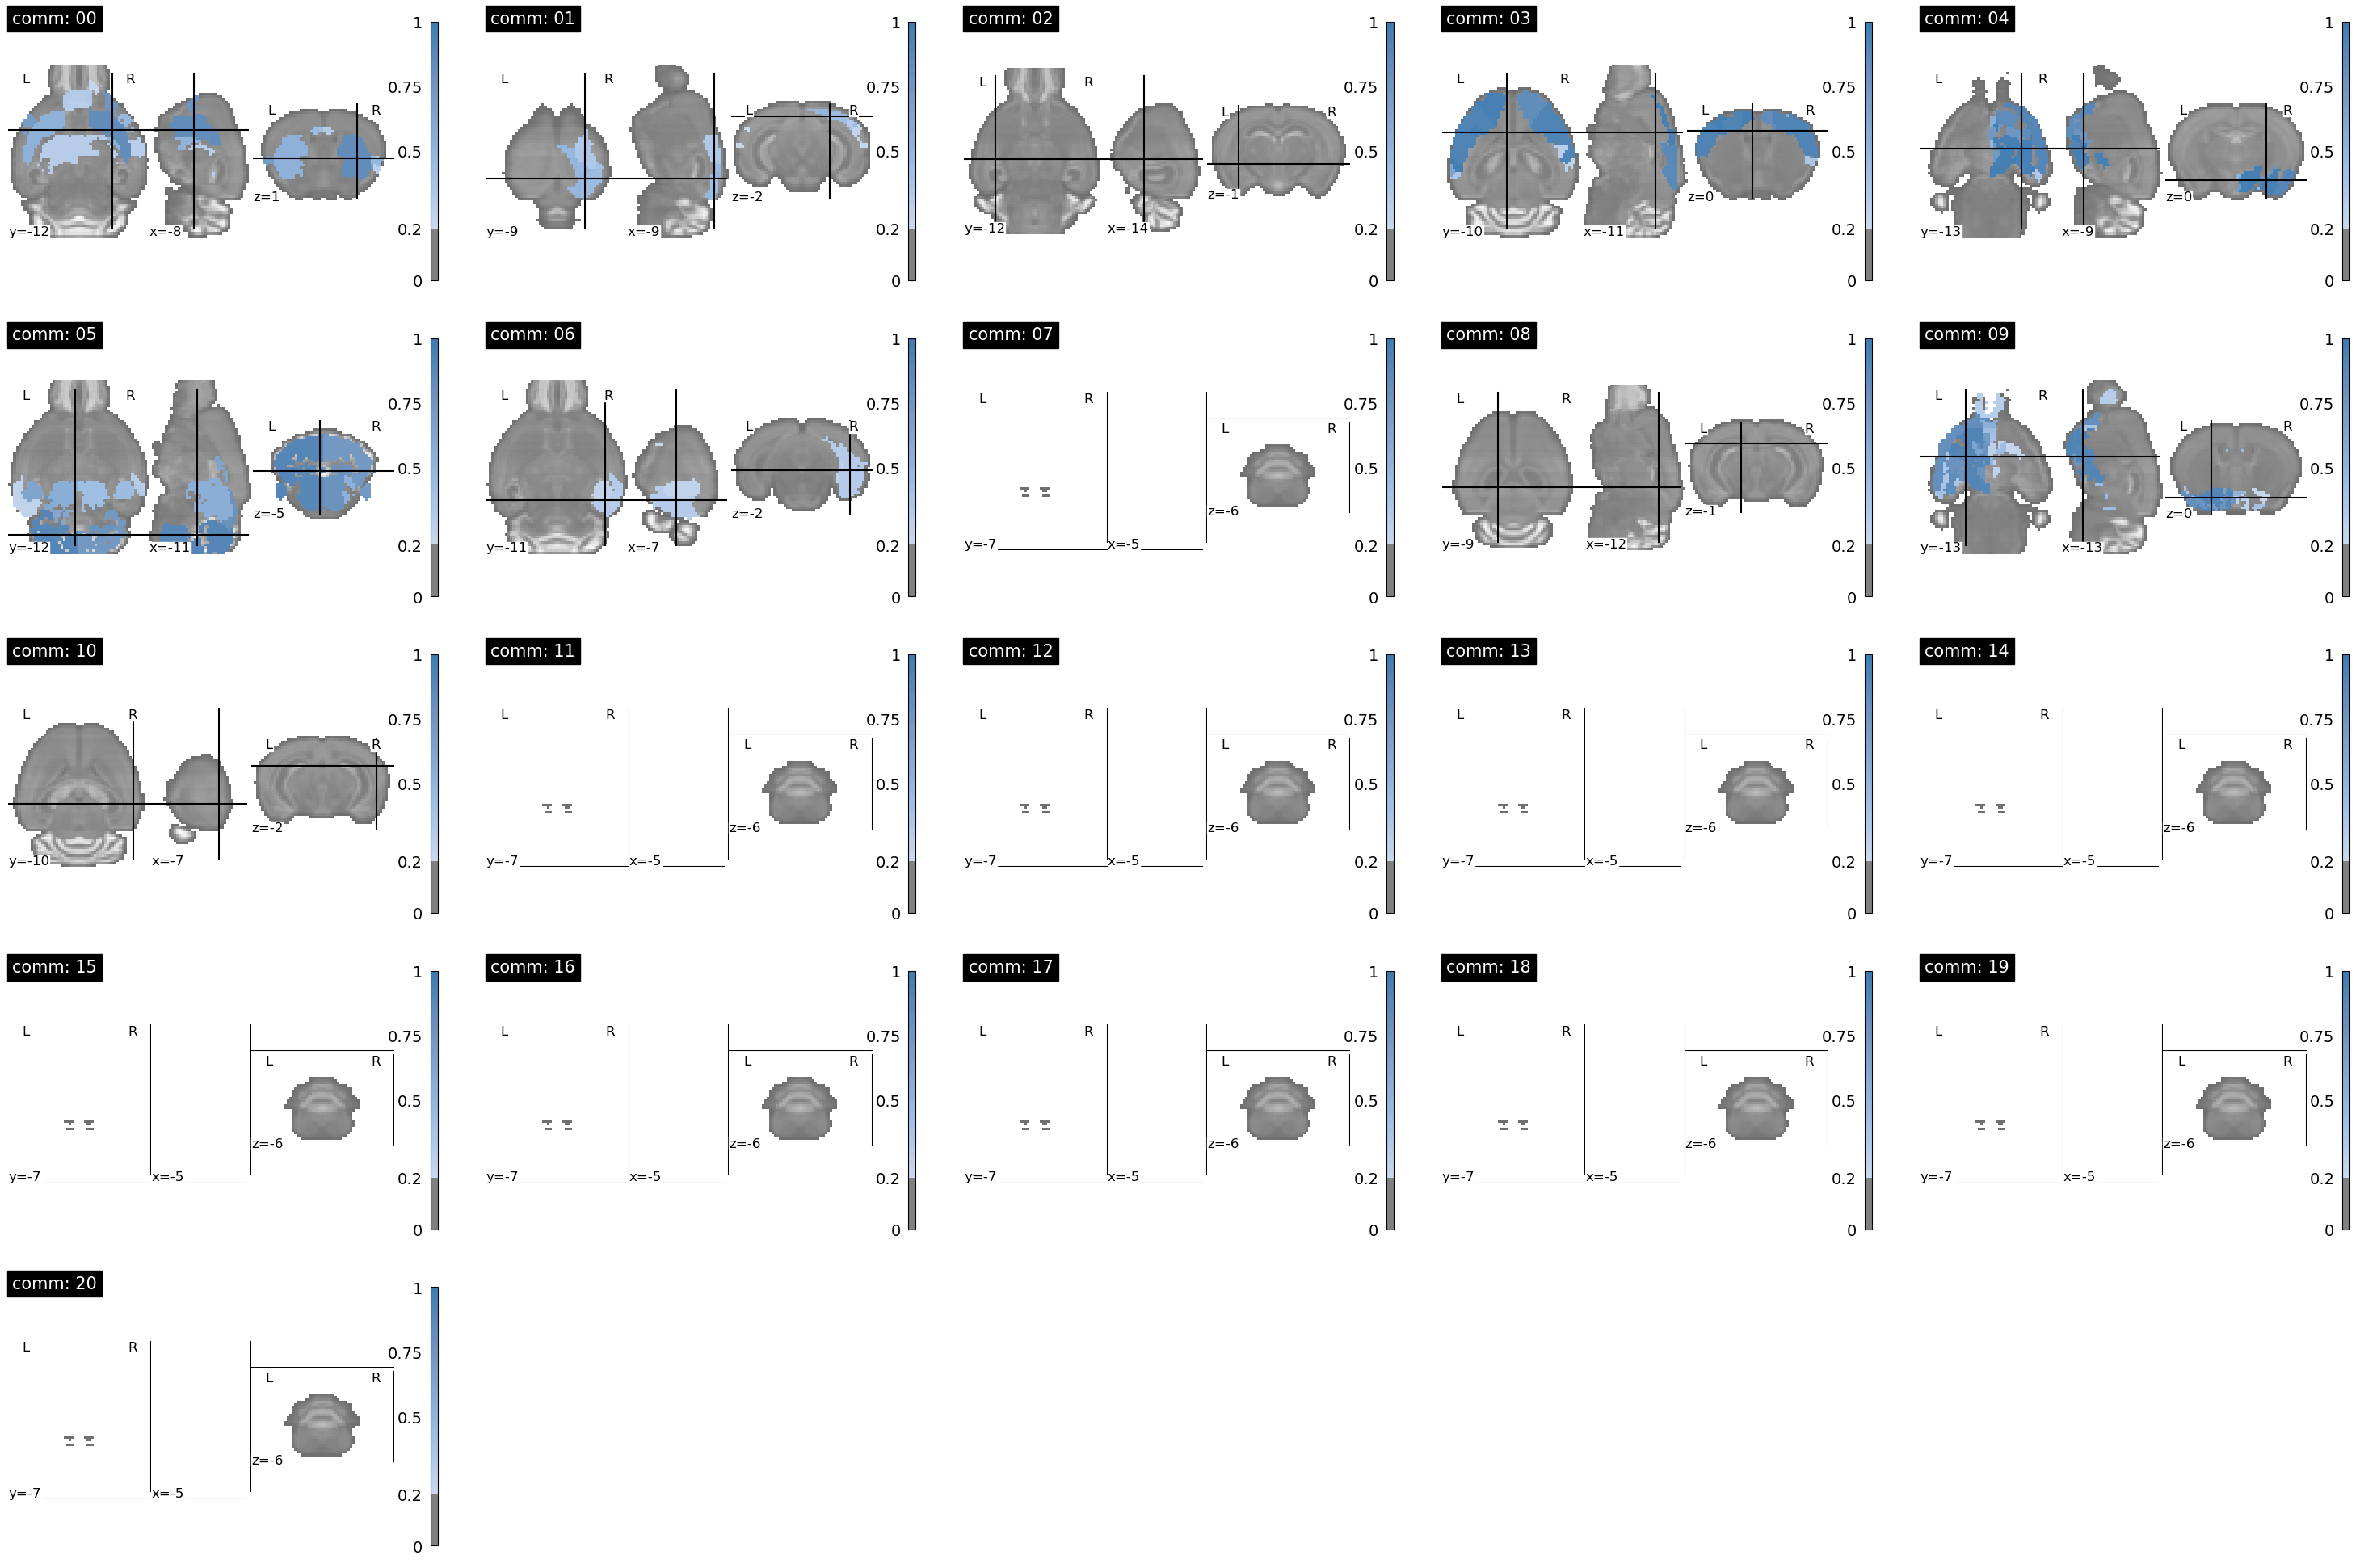

In [10]:
for comms_img_file in comms_img_files:
    fig = plot_comms_nilearn(comms_img_file)